# Generate data

First, we need to determine the episode number to generate. The episode will be saved in at ./data/episode{numer}.

In [1]:
EPISODE = 4

Then, we instate the cameras' information for later use. 

In [2]:
CAMERAS = ["top", "front", "side-1", "side-2"]

Then, we create the folder which holds the episode data.


In [3]:
import os
episode_folder_base = 'data'
episode_folder = os.path.join(episode_folder_base, f'episode{EPISODE}')
if not os.path.exists(episode_folder):
    os.makedirs(episode_folder)
for camera in CAMERAS:
    camera_depth = os.path.join(episode_folder, camera.replace("-", "_")+"_depth")
    camera_rgb = os.path.join(episode_folder, camera.replace("-", "_")+"_rgb")
    if not os.path.exists(camera_depth):
        os.makedirs(camera_depth)
    if not os.path.exists(camera_rgb):
        os.makedirs(camera_rgb)

Next thing is to read from the saves folder to generate the episode. The first step is to copy the current images from the saves folder to the data folder and re-format the names (e.g. 0.png, 1.png, ...).

In [4]:
import shutil

saves_cameras_folder = 'saves/cameras/'
for camera in CAMERAS:
    camera_folder = os.path.join(saves_cameras_folder, camera.replace("-", "_"))
    images_folder = os.path.join(camera_folder, 'images')
    images = os.listdir(images_folder)
    depth_images = [image for image in images if image.startswith('depth')]
    rgb_images = [image for image in images if image.startswith('rgb')]
    depth_images.sort()
    rgb_images.sort()
    i = 0
    depth_images_path = []
    rgb_images_path = []
    for depth_image, rgb_image in zip(depth_images, rgb_images):
        depth_image_path = os.path.join(images_folder, depth_image)
        rgb_image_path = os.path.join(images_folder, rgb_image)
        depth_image_new_path = os.path.join(episode_folder, camera.replace("-", "_")+"_depth", str(i)+".png")
        rgb_image_new_path = os.path.join(episode_folder, camera.replace("-", "_")+"_rgb", str(i)+".png")
        shutil.copyfile(depth_image_path, depth_image_new_path)
        shutil.copyfile(rgb_image_path, rgb_image_new_path)
        depth_images_path.append(depth_image_new_path)
        rgb_images_path.append(rgb_image_new_path)
        i += 1

Next step is to generate the Observation objects and save them as pickle file in the data folder.

In [5]:
import numpy as np
from rlbench.backend.observation import Observation
import pickle

extrinsics_filename = 'ex_2023_1_29_16_48_45.npy'
intrinsics_filename = 'in_2023_1_29_16_48_45.npy'

camera_far = 2
camera_near = 0.16
misc = {}
for camera in CAMERAS:
    camera_extrinsics = np.load(os.path.join(saves_cameras_folder, camera.replace("-", "_"), 'matrices', extrinsics_filename))
    camera_intrinsics = np.load(os.path.join(saves_cameras_folder, camera.replace("-", "_"), 'matrices', intrinsics_filename))
    misc[camera.replace("-", "_")+"_camera_extrinsics"] = camera_extrinsics
    misc[camera.replace("-", "_")+"_camera_intrinsics"] = camera_intrinsics
    misc[camera.replace("-", "_")+"_camera_far"] = camera_far
    misc[camera.replace("-", "_")+"_camera_near"] = camera_near

obs = []
for depth_image_path, rgb_image_path in zip(depth_images_path, rgb_images_path):
    obs.append(Observation(misc=misc))

with open(f'data/episode{EPISODE}/low_dim_obs.pkl', "wb") as f:
    pickle.dump(obs, f)    

# Visualize data

In this section, we will visualize the data we generated. We will use the Observation class to load the data and visualize it.

Demo 4 | 3 total steps



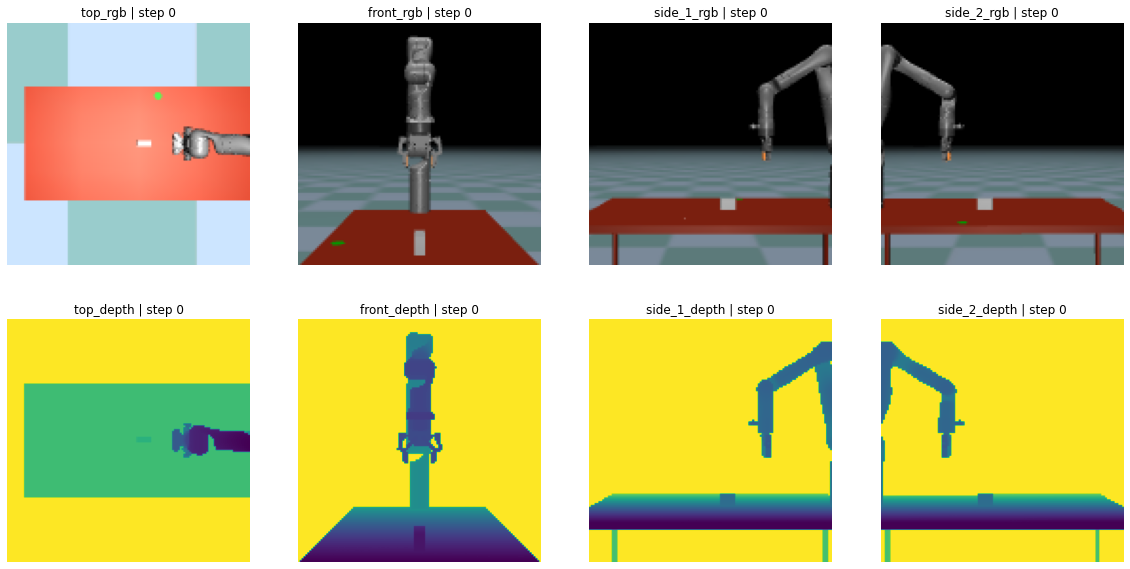

In [6]:
from rlbench.backend.utils import extract_obs
from rlbench.utils import get_stored_demo
import matplotlib.pyplot as plt

IMAGE_SIZE = 128

import pprint

# what to visualize
ts = 0 # timestep out of total timesteps
data_path = 'data'

cameras = [camera.replace("-", "_") for camera in CAMERAS]

# get demo
demo = get_stored_demo(data_path=data_path,
                       index=EPISODE)

# extract obs at timestep                 
obs_dict = extract_obs(demo[ts], cameras, t=ts)

# total timesteps in demo
print(f"Demo {EPISODE} | {len(demo)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(cameras)

plot_idx = 1
for camera in cameras:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(cameras))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

# Voxelization

In [8]:
from arm.utils import stack_on_channel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in cameras:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])
        
        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

def _obj_to_dict(obj):
    return {k: v for k, v in obj.items() if not k.startswith('_')}

def dict_to_tensor(d):
    for k, v in d.items():
        if isinstance(v, np.ndarray):
            d[k] = torch.from_numpy(v[np.newaxis, np.newaxis, ...]).to(device)
        else:
            pass
    return d

def _obj_to_tensor(obj):
    return dict_to_tensor(_obj_to_dict(obj))

In [9]:
from arm.utils import visualise_voxel
from components.voxel_grid import VoxelGrid

SCENE_BOUNDS = [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6]
VOXEL_SIZES = [100]
BATCH_SIZE = 1

# initialize voxelizer
vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(cameras),
)

# preprocess observations
batch = _obj_to_tensor(extract_obs(demo[ts], cameras))
obs, pcds = _preprocess_inputs(batch)

# flatten observations
bs = obs[0][0].shape[0]
pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# tensorize scene bounds
bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat, 
                                                    coord_features=flat_imag_features, 
                                                    coord_bounds=bounds)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

(-0.5, 1919.5, 1079.5, -0.5)

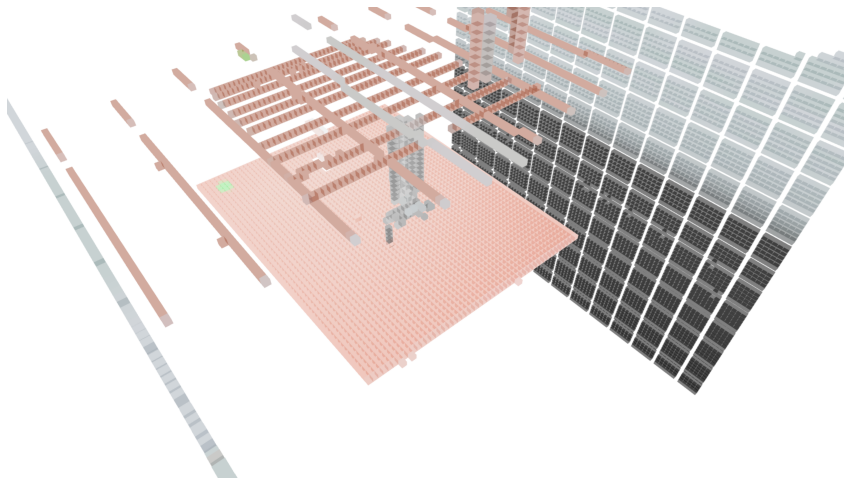

In [10]:
# render voxel grid with expert action (blue)
#@markdown #### Show voxel grid and expert action (blue)
#@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.
rotation_amount = 140 #@param {type:"slider", min:-180, max:180, step:5}
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               None,
                               voxel_size=0.045,
                               rotation_amount=np.deg2rad(rotation_amount))

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')